# Desarrollo del modulo de recorte de patente

In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_leer = "./resources/examples/img4.jpg"
# Carga la imagen
imgColor = cv2.imread(img_leer)

# Carga la imagen en escala de grises
imagen = cv2.imread(img_leer, cv2.IMREAD_GRAYSCALE)  

In [92]:
# Binarizacion

umbral_global = 150


# Aplica la binarización en toda la imagen
_, imagen_binarizada = cv2.threshold(imagen, umbral_global, 255, cv2.THRESH_BINARY)

##cv2.imshow("Imagen Binarizada con Componentes Conectados", imagen_binarizada)
# Convierte la imagen binarizada a escala de grises

# Aplica la detección de componentes conectados en la imagen binarizada en escala de grises
_, labels, stats, centroids = cv2.connectedComponentsWithStats(imagen_binarizada)


##Si descomento esto puedo ver todos los componentes detectados antes de filtrarlos
""" for i in range(1, len(stats)):
    x, y, w, h, area = stats[i]
    cv2.rectangle(imgColor, (x, y), (x + w, y + h), (0, 255, 0), 2)


cv2.imshow("Imagen Binarizada con Componentes Conectados", imgColor)
 """

' for i in range(1, len(stats)):\n    x, y, w, h, area = stats[i]\n    cv2.rectangle(imgColor, (x, y), (x + w, y + h), (0, 255, 0), 2)\n\n\ncv2.imshow("Imagen Binarizada con Componentes Conectados", imgColor)\n '

In [93]:
area_total_imagen = imagen_binarizada.size
for label in range(1, len(stats)):
    ancho = stats[label, cv2.CC_STAT_WIDTH]
    alto = stats[label, cv2.CC_STAT_HEIGHT]
    area_componente = stats[label, cv2.CC_STAT_AREA]

    relacion_aspecto = ancho / alto if ancho != 0 else 0
    relacion_area = area_total_imagen / area_componente
    if not (2.8 < relacion_aspecto < 5):
        labels[
            labels == label
        ] = 0  # Eliminar componente basado en la relación de aspecto
        stats[label] = 0  # Eliminar las estadísticas del componente

    if not (23 < relacion_area < 300):
        labels[labels == label] = 0  # Eliminar componente basado en la relación de área
        stats[label] = 0  # Eliminar las estadísticas del componente


# Convertir la matriz labels a un tipo de datos compatible
labels = np.uint8(labels)

# Remover los componentes eliminados de labels y stats
_, new_labels, new_stats, _ = cv2.connectedComponentsWithStats(labels)

# AQUI IRIA EL NUEVO FILTRO


def filtro_cambio_color_en_proporciones(imagen_binaria, proporciones):
    total_transiciones = 0

    for prop in proporciones:
        # Extraer la fila específica
        fila_a_analizar = imagen_binaria[int(imagen_binaria.shape[0] * prop), :]

        # Calcular las diferencias en la fila
        diferencias = np.abs(np.diff(fila_a_analizar))

        # Sumar las diferencias en la fila
        total_transiciones += np.sum(diferencias)

    return total_transiciones

In [94]:
proporciones_a_analizar = [1 / 4, 1 / 2, 3 / 4]

# Rango de cantidad de diferencias permitidas
rango_cantidad_diferencias = (5000, 10000)

# Nuevos labels y stats que almacenarán solo los componentes que pasan el nuevo filtro
nuevos_labels = np.zeros_like(labels)
nuevos_stats = []
indices_validos = []

In [95]:
# Iterar sobre las estadísticas de los nuevos componentes
for i in range(1, len(new_stats)):
    x, y, w, h, area = new_stats[i]

    # Reiniciar el total de transiciones para cada objeto
    total_transiciones = 0

    # Extraer la región de interés (ROI) de la imagen binarizada
    roi_a_analizar = imagen_binarizada[y : y + h, x : x + w]

    # Aplicar el filtro en las proporciones específicas
    total_transiciones = filtro_cambio_color_en_proporciones(
        roi_a_analizar, proporciones_a_analizar
    )
    print(total_transiciones)

    # Verificar si la suma total de transiciones está dentro del rango
    if not (
        rango_cantidad_diferencias[0]
        <= total_transiciones
        <= rango_cantidad_diferencias[1]
    ):
        # Imprimir la cantidad total de transiciones para cada objeto
        print(new_labels)

        print(f"Objeto {i}: Total de transiciones = {total_transiciones}")

        new_labels[
            new_labels == i
        ] = 0  # Eliminar componente basado en la relación de aspecto
        new_stats[i] = 0  # Eliminar las estadísticas del componente

7421.0


In [96]:
# Convertir la matriz nuevos_labels a un tipo de datos compatible
new_labels = np.uint8(new_labels)

# Remover el componente 0 (fondo) de los nuevos labels y stats
nuevos_labels, _, nuevos_stats, _ = cv2.connectedComponentsWithStats(new_labels)

# Después de la sección donde se aplica el filtro
print("Número de objetos válidos:", len(nuevos_stats))


# Dibuja rectángulos alrededor de los componentes conectados en la imagen original
#for i in range(1, len(nuevos_stats)):
#    x, y, w, h, area = nuevos_stats[i]
#    cv2.rectangle(imgColor, (x, y), (x + w, y + h), (0, 255, 0), 2)

Número de objetos válidos: 2


In [97]:
patente = imgColor[
    nuevos_stats[1][1] :
    nuevos_stats[1][1] + nuevos_stats[1][3],
    nuevos_stats[1][0]: 
    nuevos_stats[1][0] + nuevos_stats[1][2]
    ]
cv2.imshow('patente', patente)
cv2.waitKey(0)
cv2.destroyAllWindows()

Text(0, 0.5, 'Frecuencia')

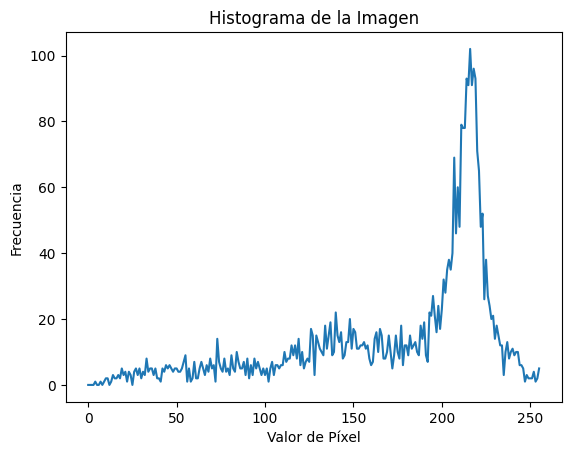

In [98]:
# Muestra el histograma usando Matplotlib

histograma = cv2.calcHist([patente], [0], None, [256], [0, 256])

plt.plot(histograma)
plt.title('Histograma de la Imagen')
plt.xlabel('Valor de Píxel')
plt.ylabel('Frecuencia')

In [99]:
# conviene binarizar ..
patente_grises = cv2.cvtColor(patente, cv2.COLOR_RGB2GRAY)

_, patente_binarizada = cv2.threshold(patente_grises, 150, 255, cv2.THRESH_BINARY)


In [100]:
cv2.imshow('patente binarizada', patente_binarizada)
cv2.waitKey(0)
cv2.destroyAllWindows()

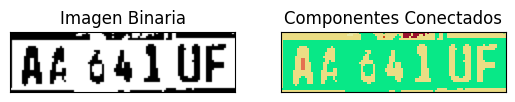

In [101]:
num_componentes, etiquetas = cv2.connectedComponents(patente_binarizada)

# Crea un mapa de colores para las etiquetas
mapa_colores = np.random.randint(0, 255, size=(num_componentes, 3), dtype=np.uint8)

# Asigna colores a los píxeles según las etiquetas
componentes_coloreados = mapa_colores[etiquetas]

# Muestra la imagen original y la imagen con componentes coloreados
plt.subplot(1, 2, 1), plt.imshow(patente_binarizada, cmap='gray')
plt.title('Imagen Binaria'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(componentes_coloreados, cv2.COLOR_BGR2RGB))
plt.title('Componentes Conectados'), plt.xticks([]), plt.yticks([])

plt.show()

9


(Text(0.5, 1.0, 'Componentes conectados detectados en patente'),
 ([], []),
 ([], []))

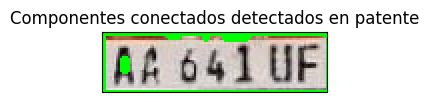

In [102]:
_, labels, stats, centroids = cv2.connectedComponentsWithStats(patente_binarizada)
patente_copia = patente.copy()
print(num_componentes)
for i in range(1, len(stats)):
    x, y, w, h, area = stats[i]
    cv2.rectangle(patente_copia, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.subplot(1, 2, 1), plt.imshow(patente_copia, cmap='gray')
plt.title('Componentes conectados detectados en patente'), plt.xticks([]), plt.yticks([])


In [103]:
altura, ancho = patente_binarizada.shape[:2]
THRESHOLD = 100

In [104]:
# Para trabajar mas comodos, recortemos las lineas que se ven en la parte superior e inferior
for i in range(altura):
    suma = 0
    for j in range(ancho): 
        suma = suma + patente_binarizada[i][j]
    if (suma/ancho) >   THRESHOLD: 
        np.delete(patente, i, 0)


In [105]:
cv2.imshow('patente sin bordes', patente)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [106]:
# Categorizemos los espacios entre las letras
# AA 111 AA 
# AA [espacio tipo 1] 111 A[espacio tipo 0]A 
